<a href="https://colab.research.google.com/github/Burnsjj/DNSC-301-Group-15/blob/main/DNSC_Project_Group_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Python Imports




In [21]:
from sklearn import tree  
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import roc_auc_score, accuracy_score

import io
from google.colab import files

import numpy as np 
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

SEED = 54321

####Training Data

In [2]:
uploaded = files.upload()

Saving credit_line_increase (1).csv to credit_line_increase (1).csv


In [3]:
type(uploaded)

dict

In [10]:
uploaded.keys()

dict_keys(['credit_line_increase (1).csv'])

In [11]:
data = pd.read_csv(io.StringIO(uploaded['credit_line_increase (1).csv'].decode('utf-8')))

#### Data Dictionary

| Name | Modeling Role | Measurement Level| Description|
| ---- | ------------- | ---------------- | ---------- |
|**ID**| ID | int | unique row indentifier |
| **LIMIT_BAL** | input | float | amount of previously awarded credit |
| **SEX** | demographic information | int | 1 = male; 2 = female
| **RACE** | demographic information | int | 1 = hispanic; 2 = black; 3 = white; 4 = asian |
| **EDUCATION** | demographic information | int | 1 = graduate school; 2 = university; 3 = high school; 4 = others |
| **MARRIAGE** | demographic information | int | 1 = married; 2 = single; 3 = others |
| **AGE** | demographic information | int | age in years |
| **PAY_0, PAY_2 - PAY_6** | inputs | int | history of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above |
| **BILL_AMT1 - BILL_AMT6** | inputs | float | amount of bill statement; BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005 |
| **PAY_AMT1 - PAY_AMT6** | inputs | float | amount of previous payment; PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005 |
| **DELINQ_NEXT**| target | int | whether a customer's next payment is delinquent (late), 1 = late; 0 = on-time |

####Basic Data Analysis

In [12]:
data.shape

(30000, 26)

In [13]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DELINQ_NEXT'],
      dtype='object')

In [14]:
data.isnull().any()

ID             False
LIMIT_BAL      False
SEX            False
RACE           False
EDUCATION      False
MARRIAGE       False
AGE            False
PAY_0          False
PAY_2          False
PAY_3          False
PAY_4          False
PAY_5          False
PAY_6          False
BILL_AMT1      False
BILL_AMT2      False
BILL_AMT3      False
BILL_AMT4      False
BILL_AMT5      False
BILL_AMT6      False
PAY_AMT1       False
PAY_AMT2       False
PAY_AMT3       False
PAY_AMT4       False
PAY_AMT5       False
PAY_AMT6       False
DELINQ_NEXT    False
dtype: bool

In [15]:
data.describe()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,2.721967,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,1.094397,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,2.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,3.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,4.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


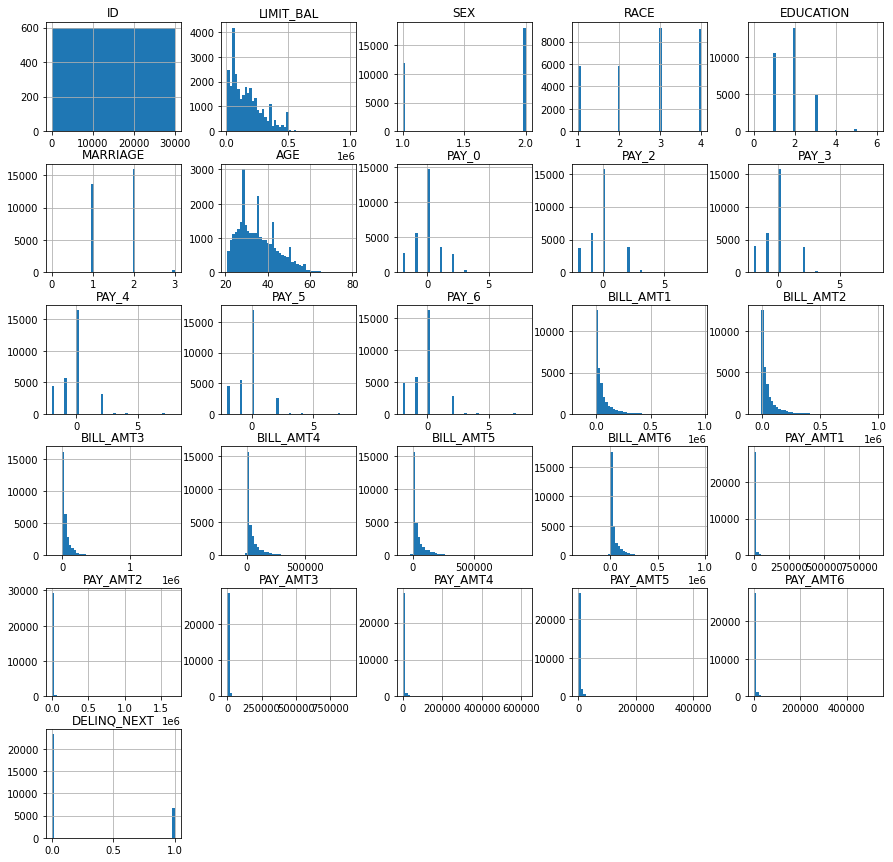

In [16]:
_ = data[data.columns].hist(bins=50, figsize=(15, 15))

In [17]:
corr = data.corr() 
corr

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
ID,1.000000,0.026179,0.018497,-0.000710,0.039177,-0.029079,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,-0.022199,-0.020270,0.019389,0.017982,0.024354,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952
LIMIT_BAL,0.026179,1.000000,0.024755,0.044173,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,-0.235195,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.018497,0.024755,1.000000,0.006149,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,-0.044008,-0.033642,-0.031183,-0.024563,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
RACE,-0.000710,0.044173,0.006149,1.000000,-0.012796,0.007010,0.001284,-0.102487,-0.082986,-0.074547,-0.072259,-0.067316,-0.054935,0.004232,0.002459,0.000543,0.000376,0.002096,0.002756,0.030069,0.012681,0.021854,0.026047,0.022148,0.020259,-0.303811
EDUCATION,0.039177,-0.219161,0.014232,-0.012796,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,0.082316,0.023581,0.018749,0.013002,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.029079,-0.108139,-0.031389,0.007010,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,0.034345,-0.023472,-0.021602,-0.024909,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.018678,0.144713,-0.090874,0.001284,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,-0.048773,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.030575,-0.271214,-0.057643,-0.102487,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,0.189859,0.179785,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.011215,-0.296382,-0.070771,-0.082986,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.234887,0.235257,0.224146,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.018494,-0.286123,-0.066096,-0.074547,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.208473,0.237295,0.227494,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253


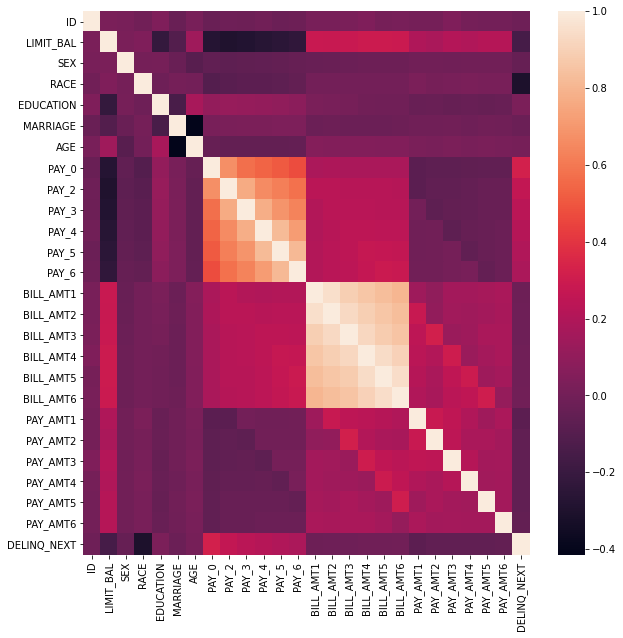

In [18]:
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

####Decision Tree

In [19]:
y_name = 'DELINQ_NEXT'
X_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [22]:
train_X, valid_test_X, train_y, valid_test_y = train_test_split(data[X_names], data[y_name], test_size=0.5, random_state=SEED)
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, random_state=SEED)

print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

del valid_test_X 
del valid_test_y

Training data: 15000 rows and 20 columns
Validation data: 7500 rows and 20 columns
Testing data: 7500 rows and 20 columns


In [23]:
max_depth = 12
candidate_models = {}

for depth in range(0, max_depth):

  clf = tree.DecisionTreeClassifier(max_depth = depth + 1, random_state=SEED)
  clf.fit(train_X, train_y)

  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std

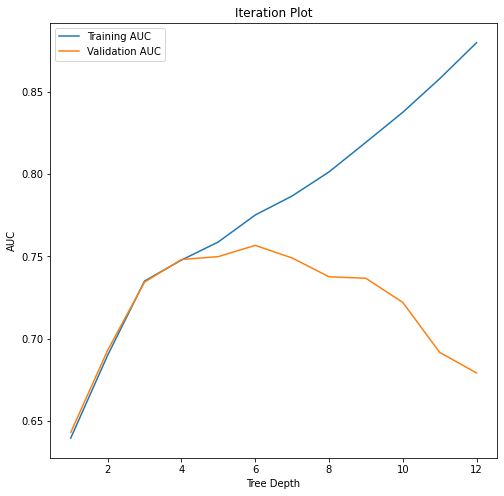

In [26]:
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC']].plot(title='Iteration Plot',
                                                               ax=ax)
_ = ax.set_xlabel('Tree Depth')
_ = ax.set_ylabel('AUC')


In [27]:
candidate_results.iloc[:, 1:]

,Training AUC,Validation AUC,5-Fold SD
1,0.639596,0.643009,0.011779
2,0.689873,0.692923,0.014208
3,0.734988,0.734357,0.010522
4,0.747747,0.748090,0.012673
5,0.758756,0.749850,0.011870
6,0.775108,0.756675,0.018227
7,0.786684,0.749026,0.019124
8,0.801313,0.737601,0.019423
9,0.819303,0.736684,0.016817
10,0.837548,0.722022,0.019353


In [30]:
best_model = candidate_models[6]['Model']
fig = plt.figure(figsize=(400, 70))
_ = tree.plot_tree(best_model,
                   feature_names=X_names,
                   class_names=['On time', 'Delinquent'],
                   filled=True)

In [31]:
test_phat = best_model.predict_proba(test_X)[:, 1]
print('Test AUC: %.4f' % roc_auc_score(test_y, test_phat))


Test AUC: 0.7596
